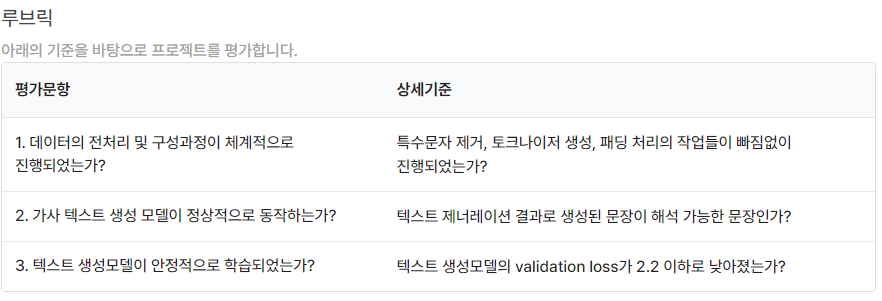

# 6-7. 프로젝트: 멋진 작사가 만들기

### 라이브러리 버전을 확인해 봅니다
----
사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import glob 
import os, re 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'


print(tf.__version__)

2.5.0


### Step 1. 데이터 다운로드
----
이미 실습(1) 데이터 다듬기에서 Cloud shell에 심볼릭 링크로 ~/aiffel/lyricist/data를 생성하셨다면, ~/aiffel/lyricist/data/lyrics에 데이터가 있습니다.

### Step 2. 데이터 읽어오기
----
glob 모듈을 사용하면 파일을 읽어오는 작업을 하기가 아주 용이해요. glob 를 활용하여 모든 txt 파일을 읽어온 후, raw_corpus 리스트에 문장 단위로 저장하도록 할게요!


```pyton
import glob
import os

txt_file_path = './data/lyrics/*' #os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. txt_file_path 에 "/root/aiffel/lyricist/data/lyrics/*" 저장

txt_list = glob.glob(txt_file_path) #txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당

raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() #read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. , splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])
```

위 코드대로 파일을 열면 
''cp949' codec can't decode byte 0xe2 in position 4: illegal multibyte sequence'라는 오류가 발생하는 경우가 있다. 
text파일의 코덱의 문제이다. 파일 읽어 들일때 encoding 파라미터를 지정해서 해결 할 수 있다. 

In [2]:
txt_file_path = './data/lyrics/*' #os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. txt_file_path 에 "/root/aiffel/lyricist/data/lyrics/*" 저장

txt_list = glob.glob(txt_file_path) #txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당

raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r", encoding='UTF8') as f:
        raw = f.read().splitlines() #read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. , splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['Looking for some education', 'Made my way into the night', 'All that bullshit conversation']


In [3]:
raw_corpus[:20]

['Looking for some education',
 'Made my way into the night',
 'All that bullshit conversation',
 "Baby, can't you read the signs? I won't bore you with the details, baby",
 "I don't even wanna waste your time",
 "Let's just say that maybe",
 'You could help me ease my mind',
 "I ain't Mr. Right But if you're looking for fast love",
 "If that's love in your eyes",
 "It's more than enough",
 'Had some bad love',
 "So fast love is all that I've got on my mind Ooh, ooh",
 'Ooh, ooh Looking for some affirmation',
 'Made my way into the sun',
 'My friends got their ladies',
 "And they're all having babies",
 "I just wanna have some fun I won't bore you with the details, baby",
 "I don't even wanna waste your time",
 "Let's just say that maybe",
 'You could help me ease my mind']

### Step 3. 데이터 정제
----
앞서 배운 테크닉들을 활용해 문장 생성에 적합한 모양새로 데이터를 정제하세요!

preprocess_sentence() 함수를 만든 것을 기억하시죠? 이를 활용해 데이터를 정제하도록 하겠습니다.

추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거합니다. 너무 긴 문장은 노래 가사 작사하기에 어울리지 않을 수도 있겠죠.
그래서 이번에는 문장을 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기 를 권합니다.

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,'¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,'¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

In [5]:
len(raw_corpus[1].split())

6

In [6]:
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    if len(preprocessed_sentence.split()) > 15: continue
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> looking for some education <end>',
 '<start> made my way into the night <end>',
 '<start> all that bullshit conversation <end>',
 "<start> i don ' t even wanna waste your time <end>",
 "<start> let ' s just say that maybe <end>",
 '<start> you could help me ease my mind <end>',
 "<start> if that ' s love in your eyes <end>",
 "<start> it ' s more than enough <end>",
 '<start> had some bad love <end>',
 '<start> ooh , ooh looking for some affirmation <end>']

In [7]:
corpus[100:200]

['<start> tears are gonna fall , rolling in the deep <end>',
 '<start> we could have had it all <end>',
 '<start> rolling in the deep <end>',
 '<start> you had my heart inside of your hand <end>',
 '<start> count your blessings to find what you look for woah <end>',
 '<start> turn my sorrow into treasured gold woah <end>',
 "<start> you ' re gonna wish you never had met me <end>",
 '<start> we could have had it all <end>',
 '<start> tears are gonna fall , rolling in the deep <end>',
 '<start> we could have had it all <end>',
 "<start> you ' re gonna wish you never had met me <end>",
 '<start> it all , it all , it all <end>',
 "<start> you ' re gonna wish you never had met me <end>",
 '<start> rolling in the deep <end>',
 '<start> tears are gonna fall , rolling in the deep <end>',
 '<start> you had my heart inside of your hand <end>',
 "<start> you ' re gonna wish you never had met me <end>",
 '<start> and you played it to the beat <end>',
 "<start> you ' re gonna wish you never had met

### Step 4. 평가 데이터셋 분리
----
#### 훈련 데이터와 평가 데이터를 분리하세요!

tokenize() 함수로 데이터를 Tensor로 변환한 후, sklearn 모듈의 train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 분리하도록 하겠습니다. 단어장의 크기는 12,000 이상 으로 설정하세요! 총 데이터의 20% 를 평가 데이터셋으로 사용해 주세요!

In [8]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=15000, 
        filters=' ',
        oov_token="<unk>"
    )
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)   
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2 290  29 ...   0   0   0]
 [  2 220  14 ...   0   0   0]
 [  2  25  16 ...   0   0   0]
 ...
 [  2  22  77 ...   0   0   0]
 [  2  41  26 ...   0   0   0]
 [  2  22  77 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x000002045DFDF730>


In [9]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 20: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : '
6 : ,
7 : the
8 : you
9 : and
10 : a
11 : to
12 : it
13 : me
14 : my
15 : in
16 : that
17 : t
18 : s
19 : on
20 : your


- 소스문장 타겟문장 생성

In [10]:
src_input = tensor[:, :-1]
tgt_input = tensor[:, 1:]

In [51]:
# tokenizer.get_config()

In [12]:
# print(len(tokenizer))
print(tensor.shape)
print(src_input.shape)
print(tgt_input.shape)

(151948, 15)
(151948, 14)
(151948, 14)


- train data와 test data분리

In [13]:
# pip install scikit-learn

In [14]:
import sklearn

print(sklearn.__version__)

1.1.3


In [15]:
from sklearn.model_selection import train_test_split

In [16]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 2022)

In [17]:
print(enc_train.shape)
print(enc_val.shape)
print(dec_train.shape)
print(dec_val.shape)

(121558, 14)
(30390, 14)
(121558, 14)
(30390, 14)


- train dataset 만들기

In [18]:
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   


dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

- validation dataset 만들기

In [19]:
BUFFER_SIZE = len(enc_val)
BATCH_SIZE = 256
steps_per_epoch = len(enc_val) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   


validation_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)
validation_dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

### Step 5. 인공지능 만들기
----
모델의 Embedding Size와 Hidden Size를 조절하며 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계하세요!

잘 설계한 모델을 학습하려면, model.fit() 함수를 사용해야 합니다. model.fit() 함수에는 다양한 인자를 넣어주어야 하는데, 가장 기본적인 인자로는 데이터셋과 epochs가 있습니다. '5. 실습 (2) 인공지능 학습시키기'에서의 예시와 같이 말이죠.

```pyton
model.fit(dataset, epochs=30)
```

하지만 model.fit() 함수의 epochs를 아무리 크게 넣는다 해도 val_loss 값은 2.2 아래로 떨어지지 않습니다. 이럴 경우는 batch size를 변경하는 것과 같이 model.fit() 함수에 다양한 인자를 넣어주면 해결될 수도 있습니다. 자세한 내용은 https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit 를 참고하세요!

Loss는 아래 제시된 Loss 함수를 그대로 사용하세요!

In [20]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옵니다!   
embedding_size = 256 # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
hidden_size = 1024 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [21]:
for src_sample, tgt_sample in dataset.take(1): break

model(src_sample)

<tf.Tensor: shape=(256, 14, 15001), dtype=float32, numpy=
array([[[-5.43981223e-05, -1.23825710e-04,  7.46838850e-05, ...,
          1.04402952e-05, -2.58132408e-04, -1.72209664e-04],
        [-1.39764770e-05, -4.45293321e-04,  2.35236468e-04, ...,
          1.31678302e-04, -1.72149725e-04, -1.99215458e-04],
        [ 2.07752764e-05, -7.00678735e-04,  3.42245796e-04, ...,
          3.05843947e-04, -2.07412289e-04, -2.12722698e-05],
        ...,
        [ 6.18376769e-04, -5.10800572e-04,  9.05491528e-04, ...,
          1.90982755e-04, -8.15841777e-05, -2.43225775e-04],
        [ 8.41552333e-04, -5.45703107e-04,  1.23212347e-03, ...,
          2.41774527e-04,  3.20664782e-04, -3.28748050e-04],
        [ 1.01176661e-03, -5.57833177e-04,  1.49023510e-03, ...,
          2.77519575e-04,  7.67198799e-04, -4.05076484e-04]],

       [[-5.43981223e-05, -1.23825710e-04,  7.46838850e-05, ...,
          1.04402952e-05, -2.58132408e-04, -1.72209664e-04],
        [-1.04611812e-04,  5.37337473e-05, -2

In [22]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3840256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  15376025  
Total params: 32,855,961
Trainable params: 32,855,961
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
474/474 [==============================] - 45s 80ms/step - loss: 3.5497 - val_loss: 3.1601
Epoch 2/10
474/474 [==============================] - 36s 76ms/step - loss: 3.0458 - val_loss: 2.9934
Epoch 3/10
474/474 [==============================] - 36s 76ms/step - loss: 2.8888 - val_loss: 2.8879
Epoch 4/10
474/474 [==============================] - 36s 76ms/step - loss: 2.7648 - val_loss: 2.8070
Epoch 5/10
474/474 [==============================] - 37s 77ms/step - loss: 2.6603 - val_loss: 2.7471
Epoch 6/10
474/474 [==============================] - 37s 77ms/step - loss: 2.5676 - val_loss: 2.6987
Epoch 7/10
474/474 [==============================] - 37s 77ms/step - loss: 2.4825 - val_loss: 2.6582
Epoch 8/10
474/474 [==============================] - 36s 76ms/step - loss: 2.4033 - val_loss: 2.6226
Epoch 9/10
474/474 [==============================] - 37s 77ms/step - loss: 2.3299 - val_loss: 2.5916
Epoch 10/10
474/474 [==============================] - 37s 77ms/step - loss: 2.259

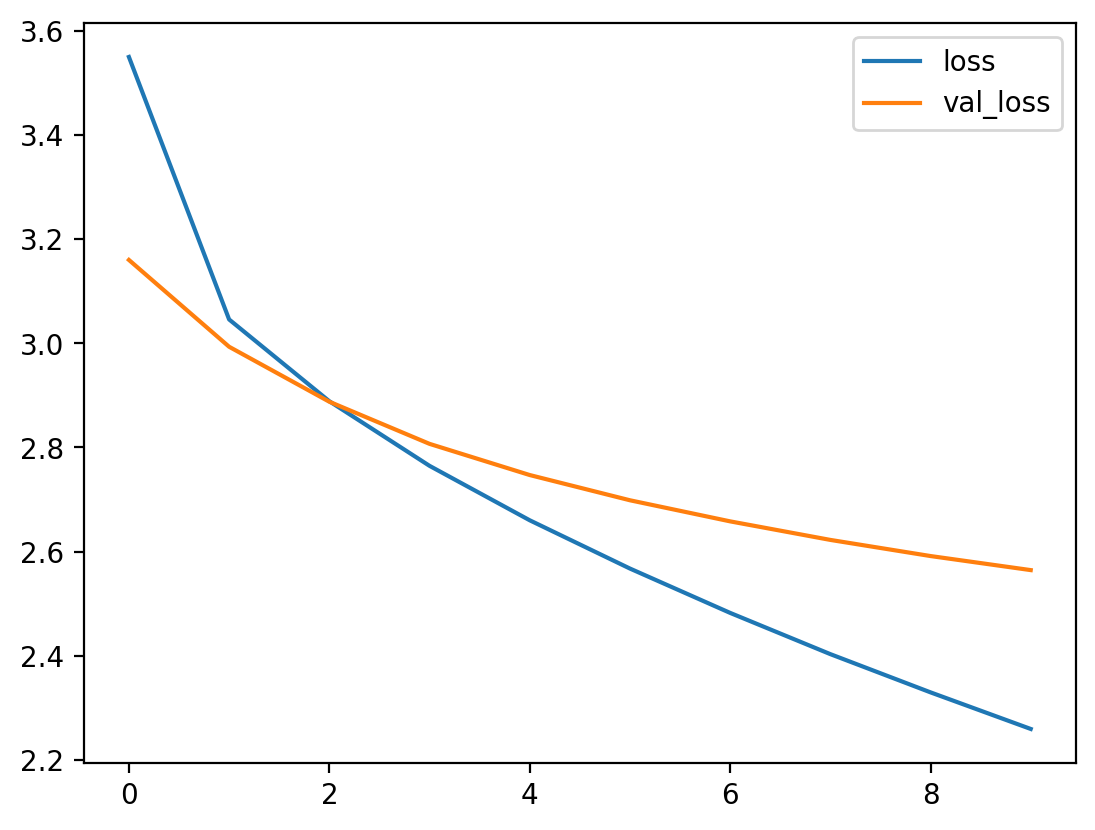

In [23]:
#Loss
# tf.keras.losses.SparseCategoricalCrossentropy : https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, reduction='none') # 클래스 분류 문제에서 softmax 함수를 거치면 from_logits = False(default값),그렇지 않으면 from_logits = True.

model.compile(loss=loss, optimizer=optimizer)
history = model.fit(dataset, epochs=10, validation_data = (validation_dataset))

print('''


''')
plt.figure()

for k,v in history.history.items():
    plt.plot(history.history[k], label=k)
plt.legend()
plt.show()

In [28]:
print(history.history)

{'loss': [3.5497348308563232, 3.0458273887634277, 2.88883900642395, 2.76481032371521, 2.660278797149658, 2.5676209926605225, 2.4825024604797363, 2.403327703475952, 2.3299269676208496, 2.2596778869628906], 'val_loss': [3.160074472427368, 2.993394374847412, 2.8878815174102783, 2.806997776031494, 2.7471323013305664, 2.698700428009033, 2.6582067012786865, 2.622598886489868, 2.5916192531585693, 2.5646233558654785]}


In [30]:
#문장생성 함수 정의
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20): #시작 문자열을 init_sentence 로 받으며 디폴트값은 <start> 를 받는다
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다 (도달 하지 못하였으면 while 루프를 돌면서 다음 단어를 예측)
    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성성
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

In [32]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)
# generate_text 함수에 lyricist 라 정의한 모델을 이용해서 ilove 로 시작되는 문장을 생성

'<start> i love you <end> '

In [34]:
generate_text(model, tokenizer, init_sentence="<start> i miss", max_len=20)
# generate_text 함수에 lyricist 라 정의한 모델을 이용해서 ilove 로 시작되는 문장을 생성

'<start> i miss you <end> '

In [35]:
generate_text(model, tokenizer, init_sentence="<start> i always", max_len=20)
# generate_text 함수에 lyricist 라 정의한 모델을 이용해서 ilove 로 시작되는 문장을 생성

'<start> i always want to be with you <end> '

### 소결론1
- 모델은 나름 잘 돌아가나 loss값이 충분히 줄어들지 않았다. 
- 파라미터를 조절해서 loss값을 줄여보기로 한다. 모델면은 lyricist_00로 한다. 

In [37]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옵니다!   
embedding_size = 512 # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
hidden_size = 2048 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
lyricist_01 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

Epoch 1/10
474/474 [==============================] - 83s 163ms/step - loss: 2.9262 - val_loss: 2.7586
Epoch 2/10
474/474 [==============================] - 76s 159ms/step - loss: 2.5157 - val_loss: 2.5194
Epoch 3/10
474/474 [==============================] - 77s 161ms/step - loss: 2.1355 - val_loss: 2.3577
Epoch 4/10
474/474 [==============================] - 76s 160ms/step - loss: 1.7989 - val_loss: 2.2561
Epoch 5/10
474/474 [==============================] - 76s 160ms/step - loss: 1.5202 - val_loss: 2.1967
Epoch 6/10
474/474 [==============================] - 77s 161ms/step - loss: 1.3038 - val_loss: 2.1666
Epoch 7/10
474/474 [==============================] - 82s 173ms/step - loss: 1.1495 - val_loss: 2.1660
Epoch 8/10
474/474 [==============================] - 82s 173ms/step - loss: 1.0556 - val_loss: 2.1869
Epoch 9/10
474/474 [==============================] - 77s 162ms/step - loss: 1.0036 - val_loss: 2.2063
Epoch 10/10
474/474 [==============================] - 77s 161ms/step - l

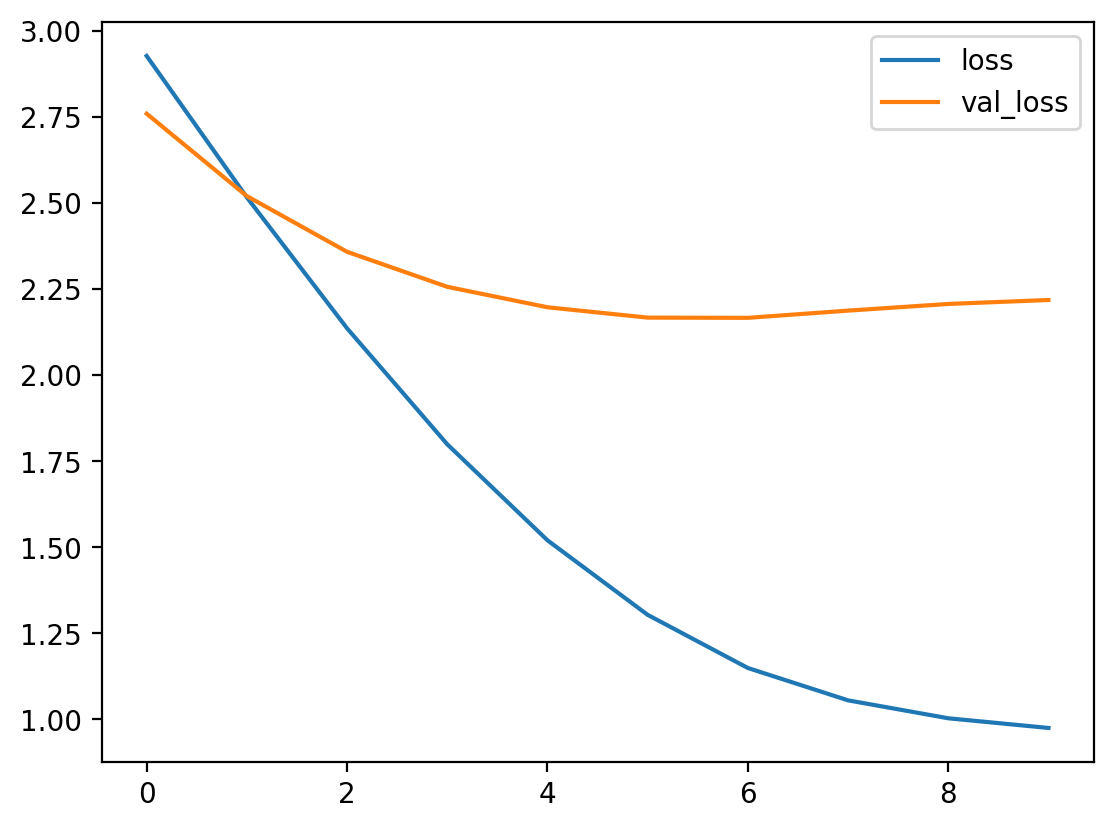

In [39]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, reduction='none') # 클래스 분류 문제에서 softmax 함수를 거치면 from_logits = False(default값),그렇지 않으면 from_logits = True.

lyricist_01.compile(loss=loss, optimizer=optimizer)
history_01 = lyricist_01.fit(dataset, epochs=10, validation_data = (validation_dataset))

print('''

''')
model.summary()
print('''

''')
plt.figure()

for k,v in history_01.history.items():
    plt.plot(history_01.history[k], label=k)
plt.legend()
plt.show()

In [40]:
embedding_size = 1024 
hidden_size = 2048
lyricist_02 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

Epoch 1/10
474/474 [==============================] - 169s 221ms/step - loss: 3.3032 - val_loss: 2.9259
Epoch 2/10
474/474 [==============================] - 104s 219ms/step - loss: 2.7569 - val_loss: 2.6937
Epoch 3/10
474/474 [==============================] - 105s 220ms/step - loss: 2.4734 - val_loss: 2.5325
Epoch 4/10
474/474 [==============================] - 103s 216ms/step - loss: 2.2042 - val_loss: 2.4043
Epoch 5/10
474/474 [==============================] - 104s 218ms/step - loss: 1.9492 - val_loss: 2.3098
Epoch 6/10
474/474 [==============================] - 104s 219ms/step - loss: 1.7127 - val_loss: 2.2390
Epoch 7/10
474/474 [==============================] - 102s 215ms/step - loss: 1.5016 - val_loss: 2.1899
Epoch 8/10
474/474 [==============================] - 103s 217ms/step - loss: 1.3229 - val_loss: 2.1625
Epoch 9/10
474/474 [==============================] - 103s 217ms/step - loss: 1.1803 - val_loss: 2.1566
Epoch 10/10
474/474 [==============================] - 106s 224m

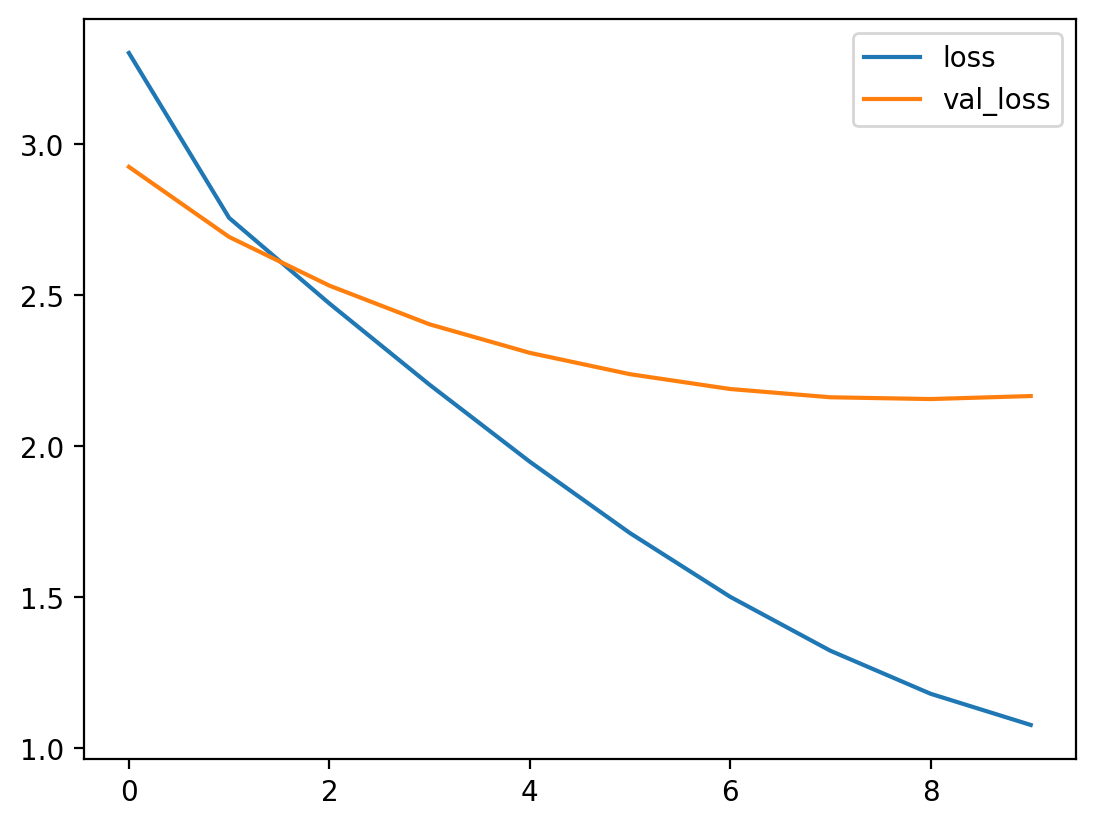

In [41]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, reduction='none') # 클래스 분류 문제에서 softmax 함수를 거치면 from_logits = False(default값),그렇지 않으면 from_logits = True.

lyricist_02.compile(loss=loss, optimizer=optimizer)
history_02 = lyricist_02.fit(dataset, epochs=10, validation_data = (validation_dataset))

print('''

''')
model.summary()
print('''

''')
plt.figure()

for k,v in history_02.history.items():
    plt.plot(history_02.history[k], label=k)
plt.legend()
plt.show()

### 소결론 2
- 오랜 기다림 끝에 10epochs만에 loss 2.2이하를 달성했다. 
- 테스트는 이것으로 마무리 짓는다. 

데이터가 커서 훈련하는 데 시간이 제법 걸릴 겁니다. 여유를 가지고 작업하시면 좋아요 :)

마지막으로 멋진 모델이 생성한 가사 한 줄을 제출하시길 바랍니다!

In [42]:
generate_text(lyricist_02, tokenizer, init_sentence="<start> i love", max_len=20)
# generate_text 함수에 lyricist 라 정의한 모델을 이용해서 ilove 로 시작되는 문장을 생성

"<start> i love you , i ' m not gonna crack <end> "

In [46]:
generate_text(lyricist_02, tokenizer, init_sentence="<start> i", max_len=20)
# generate_text 함수에 lyricist 라 정의한 모델을 이용해서 ilove 로 시작되는 문장을 생성

"<start> i ' m the one <end> "

In [50]:
generate_text(lyricist_02, tokenizer, init_sentence="<start> i miss", max_len=20)
# generate_text 함수에 lyricist 라 정의한 모델을 이용해서 ilove 로 시작되는 문장을 생성

"<start> i miss you , i ' m not gonna crack <end> "

__Q4. 모델이 생성한 가사 한 줄을 제출하세요.__
> i love you , i ' m not gonna crack

# 회고

### 신경쓴점
- 10epoch안에 validation data를 통한 loss값이 2.2 밑으로 떨어지도록 했다. 
- 데이터 전처리 과정에서 '(apostrophe)를 인식해서 문장 조합 할 때 쓸 수 있도록 시도했다. 
- train data와 validation data를 분리해서 loss값을 계산했다. 
- loss값의 추이를 시작화 했다. 

### 아쉬운점
- 따라서 작성했으나 아직 잘 모르는 코드가 있다. 
- 모델이 가장 확률이 높은 단어를 도출하다보니 하나의 문장만 내놓고 있다. 

### 시도해보고 싶은 점
- 같은 시퀀스를 주어졌을 때 다양한 문장을 생성 할 수 있도록 해보고 싶다. 방법은 아직 모르겠다. 

## Reference
- https://www.tensorflow.org/guide/keras/rnn?hl=ko#%EC%84%B1%EB%8A%A5_%EC%B5%9C%EC%A0%81%ED%99%94_%EB%B0%8F_cudnn_%EC%BB%A4%EB%84%90
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM/?hl=ko
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
- https://richdad-project.tistory.com/82
- https://towardsdatascience.com/how-to-break-gpu-memory-boundaries-even-with-large-batch-sizes-7a9c27a400ce
- LMS